# Importing Essential Libraries for Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt.space import Real, Integer, Categorical
from skopt import gp_minimize
from skopt.plots import plot_convergence

import shap
shap.initjs()

# Extracting imputed database

In [2]:
db = pd.read_csv("TiAl_prep-db_YS-ET_TS-final_El_imp-3.csv")
db = db.iloc[:,1:]
db

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Ru,Ni,Y,Re,TestT,logYS,logTS,logEl,logHV,logCost
0,53.000,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,3.060000,2.82,0.14,2.487138,0.582839
1,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,3.040000,2.81,0.14,2.472756,0.593444
2,52.486,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,2.820000,2.74,-0.14,2.519828,0.657259
3,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,3.040000,2.81,0.14,2.484300,0.593444
4,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,3.040000,2.81,0.14,2.510545,0.593444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,60.600,39.4,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,2.412133,2.53,-0.21,NaN,0.603887
1933,60.600,39.4,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,2.412098,2.53,-0.21,NaN,0.603887
1934,60.600,39.4,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,2.412063,2.53,-0.21,NaN,0.603887
1935,60.600,39.4,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,2.412028,2.53,-0.21,NaN,0.603887


In [3]:
db = pd.concat([db.iloc[:,:-2],db.iloc[:,-1]],axis=1)
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ti       1937 non-null   float64
 1   Al       1937 non-null   float64
 2   Mn       1937 non-null   float64
 3   Nb       1937 non-null   float64
 4   Cr       1937 non-null   float64
 5   Mo       1937 non-null   float64
 6   V        1937 non-null   float64
 7   Zr       1937 non-null   float64
 8   Hf       1937 non-null   int64  
 9   O        1937 non-null   float64
 10  Ta       1937 non-null   float64
 11  Si       1937 non-null   float64
 12  W        1937 non-null   float64
 13  C        1937 non-null   float64
 14  B        1937 non-null   float64
 15  Fe       1937 non-null   float64
 16  Ru       1937 non-null   float64
 17  Ni       1937 non-null   int64  
 18  Y        1937 non-null   float64
 19  Re       1937 non-null   float64
 20  TestT    1937 non-null   int64  
 21  logYS    1937 

#### Extracting input columns and all the desired properties

In [4]:
X = db.iloc[:,:-4]
X.head()

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Si,W,C,B,Fe,Ru,Ni,Y,Re,TestT
0,53.000,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0,0.0,0.0,298
1,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.014,0.0,0.0,0,0.0,0.0,298
2,52.486,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.5,0.0,0.014,0.0,0.0,0,0.0,0.0,298
3,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.014,0.0,0.0,0,0.0,0.0,298
4,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.014,0.0,0.0,0,0.0,0.0,298


In [5]:
y = db.iloc[:,-4:]
y.head()

,logYS,logTS,logEl,logCost
0,3.06,2.82,0.14,0.582839
1,3.04,2.81,0.14,0.593444
2,2.82,2.74,-0.14,0.657259
3,3.04,2.81,0.14,0.593444
4,3.04,2.81,0.14,0.593444


In [6]:
scalerX = StandardScaler()
X_transform = scalerX.fit_transform(X)
scalerY = StandardScaler()
y_transform = scalerY.fit_transform(y)

In [7]:
features = X.columns.values
features

array(['Ti', 'Al', 'Mn', 'Nb', 'Cr', 'Mo', 'V', 'Zr', 'Hf', 'O', 'Ta',
       'Si', 'W', 'C', 'B', 'Fe', 'Ru', 'Ni', 'Y', 'Re', 'TestT'],
      dtype=object)

In [8]:
response = y.columns.values
response

array(['logYS', 'logTS', 'logEl', 'logCost'], dtype=object)

In [9]:
X_transform = pd.DataFrame(X_transform,columns=features)
X_transform

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Si,W,C,B,Fe,Ru,Ni,Y,Re,TestT
0,0.297580,0.261366,-0.356195,-0.641382,-0.829804,-0.222458,-0.171936,-0.125087,-0.055742,-0.074461,...,-0.397872,-0.140300,-0.131433,-0.359922,-0.085214,-0.051341,-0.03215,-0.097816,-0.022727,-0.422982
1,0.295132,0.261366,-0.356195,-0.641382,-0.829804,-0.222458,-0.171936,-0.125087,-0.055742,-0.074461,...,-0.397872,-0.140300,-0.131433,-0.314891,-0.085214,-0.051341,-0.03215,-0.097816,-0.022727,-0.422982
2,0.207705,0.261366,-0.356195,-0.641382,-0.829804,-0.222458,-0.171936,-0.125087,-0.055742,-0.074461,...,-0.397872,2.174534,-0.131433,-0.314891,-0.085214,-0.051341,-0.03215,-0.097816,-0.022727,-0.422982
3,0.295132,0.261366,-0.356195,-0.641382,-0.829804,-0.222458,-0.171936,-0.125087,-0.055742,-0.074461,...,-0.397872,-0.140300,-0.131433,-0.314891,-0.085214,-0.051341,-0.03215,-0.097816,-0.022727,-0.422982
4,0.295132,0.261366,-0.356195,-0.641382,-0.829804,-0.222458,-0.171936,-0.125087,-0.055742,-0.074461,...,-0.397872,-0.140300,-0.131433,-0.314891,-0.085214,-0.051341,-0.03215,-0.097816,-0.022727,-0.422982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,1.626471,-1.111560,-0.356195,-0.641382,-0.829804,-0.222458,-0.171936,-0.125087,-0.055742,-0.074461,...,-0.397872,-0.140300,-0.131433,-0.359922,-0.085214,-0.051341,-0.03215,-0.097816,-0.022727,-0.422982
1933,1.626471,-1.111560,-0.356195,-0.641382,-0.829804,-0.222458,-0.171936,-0.125087,-0.055742,-0.074461,...,-0.397872,-0.140300,-0.131433,-0.359922,-0.085214,-0.051341,-0.03215,-0.097816,-0.022727,-0.422982
1934,1.626471,-1.111560,-0.356195,-0.641382,-0.829804,-0.222458,-0.171936,-0.125087,-0.055742,-0.074461,...,-0.397872,-0.140300,-0.131433,-0.359922,-0.085214,-0.051341,-0.03215,-0.097816,-0.022727,-0.422982
1935,1.626471,-1.111560,-0.356195,-0.641382,-0.829804,-0.222458,-0.171936,-0.125087,-0.055742,-0.074461,...,-0.397872,-0.140300,-0.131433,-0.359922,-0.085214,-0.051341,-0.03215,-0.097816,-0.022727,-0.422982


In [10]:
y_transform = pd.DataFrame(y_transform,columns=response)
y_transform

,logYS,logTS,logEl,logCost
0,2.192786,0.889462,-0.009595,-0.453249
1,2.107526,0.842564,-0.009595,-0.420331
2,1.169670,0.514278,-0.533331,-0.222245
3,2.107526,0.842564,-0.009595,-0.420331
4,2.107526,0.842564,-0.009595,-0.420331
...,...,...,...,...
1932,-0.569057,-0.470579,-0.664265,-0.387916
1933,-0.569208,-0.470579,-0.664265,-0.387916
1934,-0.569359,-0.470579,-0.664265,-0.387916
1935,-0.569508,-0.470579,-0.664265,-0.387916


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_transform, test_size=0.2, random_state=0)

# Defining functions to calculate CV metric scores

In [12]:
from sklearn import metrics

# Function to return the mean of the metric for a particular metric name
def metrics_mean(y_ac, y_pred, metric):
    score = {'logYS':[],'logTS':[],'logEl':[],'logCost':[]}
    n = ['logYS','logTS','logEl','logCost']
    if metric == 'rmse':
        for i in range(len(n)):
            score[n[i]].append(np.sqrt(metrics.mean_squared_error(y_ac[:,i], y_pred[:,i])))
    elif metric == 'mae':
        for i in range(len(n)):
            score[n[i]].append(metrics.mean_absolute_error(y_ac[:,i], y_pred[:,i]))
    elif metric == 'R2':
        for i in range(len(n)):
            score[n[i]].append(metrics.r2_score(y_ac[:,i], y_pred[:,i]))
    else:
        for i in range(len(n)):
            score[n[i]] = np.inf
    return score

# Final function "plot" to plot the train-train predicted values, test-test predicted values and the metrics for
# each ML algorithm used
def plot(regressor_name, y_train, y_train_pred, y_test, y_test_pred):
    
    y_train = scalerY.inverse_transform(y_train)
    y_pred_train = scalerY.inverse_transform(y_train_pred)
    y_test = scalerY.inverse_transform(y_test)
    y_pred_test = scalerY.inverse_transform(y_test_pred)

    n = ['logYS','logTS','logEl','logCost']
    xtl = [r'$log_{10}\sigma_y$', r'$log_{10}\sigma$', r'$log_{10}\delta$', r'$log_{10}Cost$']
    f, axes = plt.subplots(len(n), 2, figsize=(12,24))
    
    # training set
    for i in range(len(n)):
        # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
        axes[i,0].scatter(y_train[:,i],y_pred_train[:,i])
        axes[i,0].plot(y_train[:,i],y_train[:,i],'k--',lw=3)

        axes[i,0].set_xlabel('True Value',fontsize=16)
        axes[i,0].set_ylabel('Predicted Value',fontsize=16)

        # calculate the metrics
        rmse = metrics_mean(y_train,y_pred_train,'rmse')  
        mae = metrics_mean(y_train,y_pred_train,'mae')
        R2 = metrics_mean(y_train,y_pred_train,'R2')
        
        # regressor name with all metrics in the title
        axes[i,0].set_title(regressor_name+' training set'
        +'\nRMSE for '+xtl[i]+': '+str(round(rmse[n[i]][0],3))
        +'\nMAE for '+xtl[i]+': '+str(round(mae[n[i]][0],3))
        +'\nR2 for '+xtl[i]+': '+str(round(R2[n[i]][0],3)),fontsize=16, pad=10)
    
    # test set
    for i in range(len(n)):
        # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
        axes[i,1].scatter(y_test[:,i],y_pred_test[:,i])
        axes[i,1].plot(y_test[:,i],y_test[:,i],'k--',lw=3)
        
        axes[i,1].set_xlabel('True Value',fontsize=16)
        axes[i,1].set_ylabel('Predicted Value',fontsize=16)
        
        # calculate the metrics
        rmse = metrics_mean(y_test,y_pred_test,'rmse')  
        mae = metrics_mean(y_test,y_pred_test,'mae')
        R2 = metrics_mean(y_test,y_pred_test,'R2')
        
        # regressor name with all metrics in the title
        axes[i,1].set_title(regressor_name+' training set'
        +'\nRMSE for '+xtl[i]+': '+str(round(rmse[n[i]][0],3))
        +'\nMAE for '+xtl[i]+': '+str(round(mae[n[i]][0],3))
        +'\nR2 for '+xtl[i]+': '+str(round(R2[n[i]][0],3)),fontsize=16, pad=10)
    
    plt.tight_layout()
    plt.show()

    # return metrics for test set to record the errors across different algorithms
    return rmse, mae, R2

Empty metrics dictionaries to store the metrics for every ML algorithm

In [13]:
rmse_scores = {}
mae_scores = {}
R2_scores = {}

## MPR Random Forest model and BO

In [14]:
from sklearn.ensemble import RandomForestRegressor

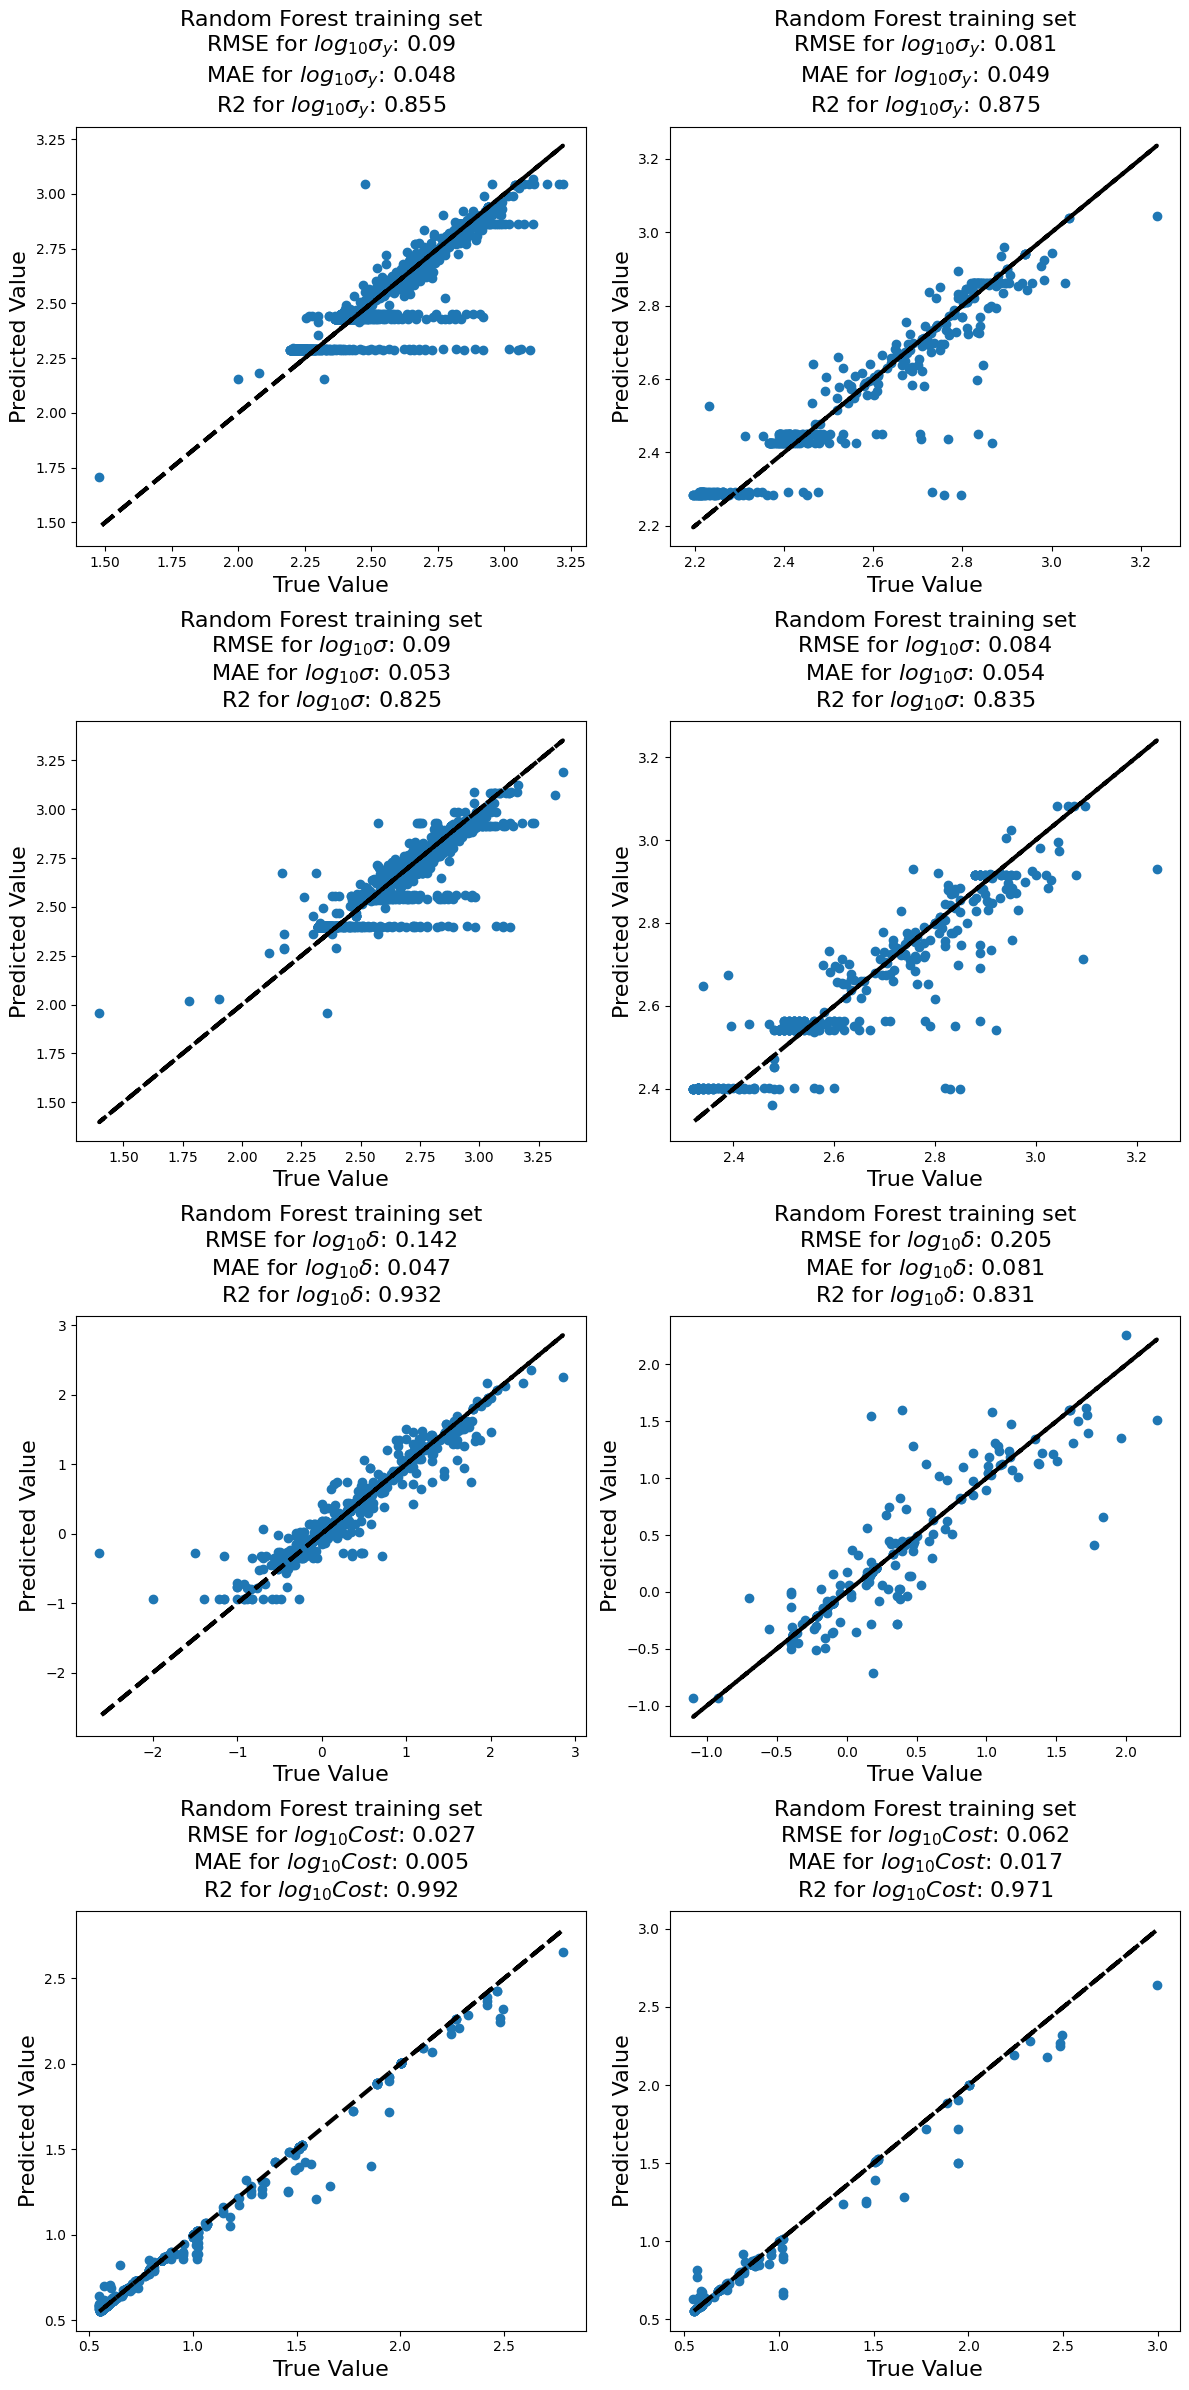

In [15]:
# Random Forest Regression
rfregressor = RandomForestRegressor(n_estimators=496, max_depth=26, random_state=0)

rfregressor.fit(X_train,y_train)
y_pred_train = rfregressor.predict(X_train)
y_pred_test = rfregressor.predict(X_test)

rmse, mae, R2 = plot('Random Forest', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Random Forest'] = rmse
mae_scores['Random Forest'] = mae
R2_scores['Random Forest'] = R2

In [16]:
# Get SHAP values
rfexplainer = shap.TreeExplainer(rfregressor)
rf_shap_values = rfexplainer(X_test)
np.shape(rf_shap_values.values)

(388, 21, 4)

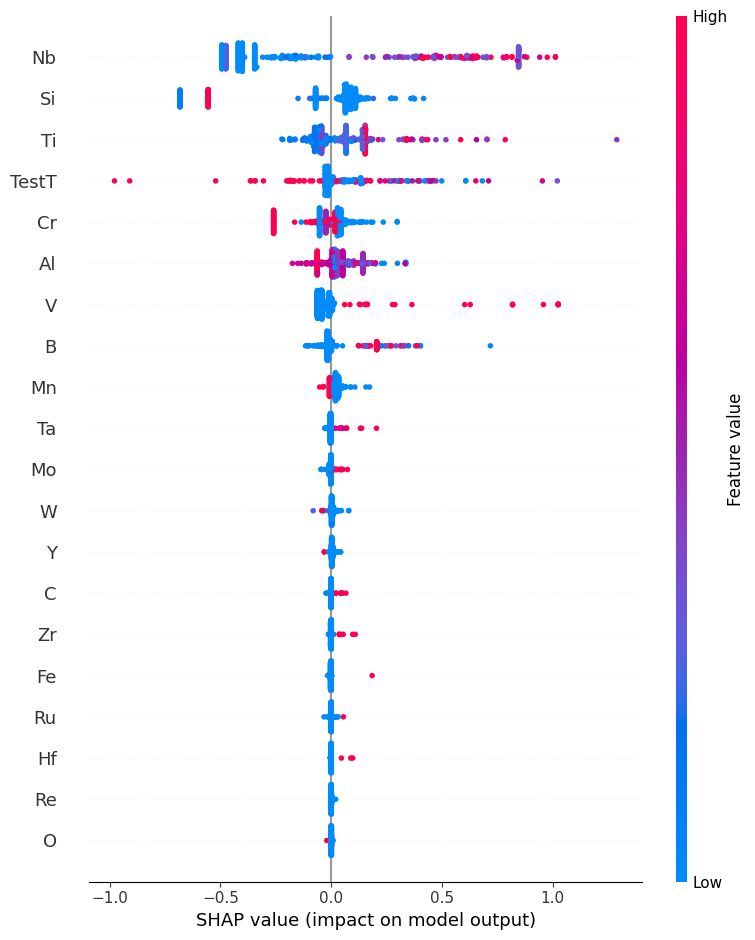

In [17]:
# Summary plot for logYS
shap.summary_plot(rf_shap_values[:,:,0])

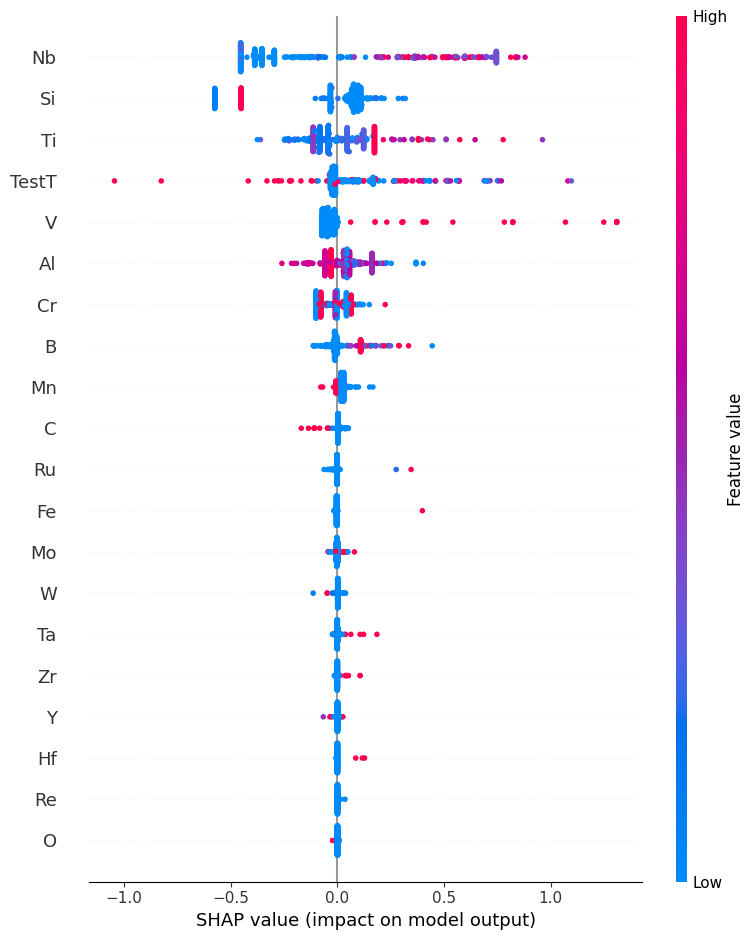

In [18]:
# Summary plot for logTS
shap.summary_plot(rf_shap_values[:,:,1])

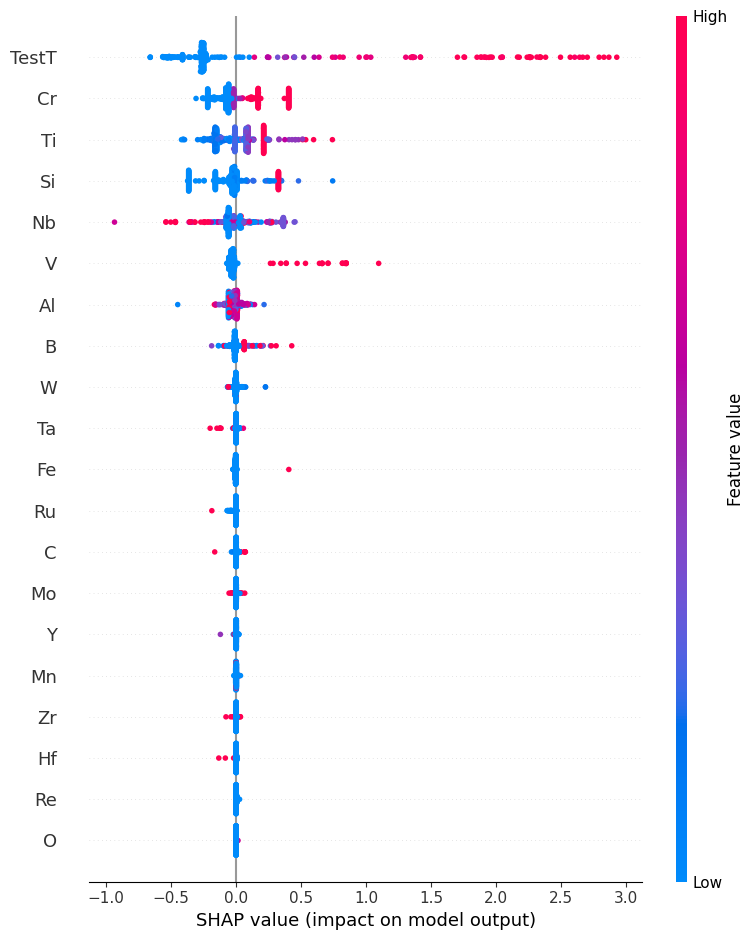

In [19]:
# Summary plot for logEl
shap.summary_plot(rf_shap_values[:,:,2])

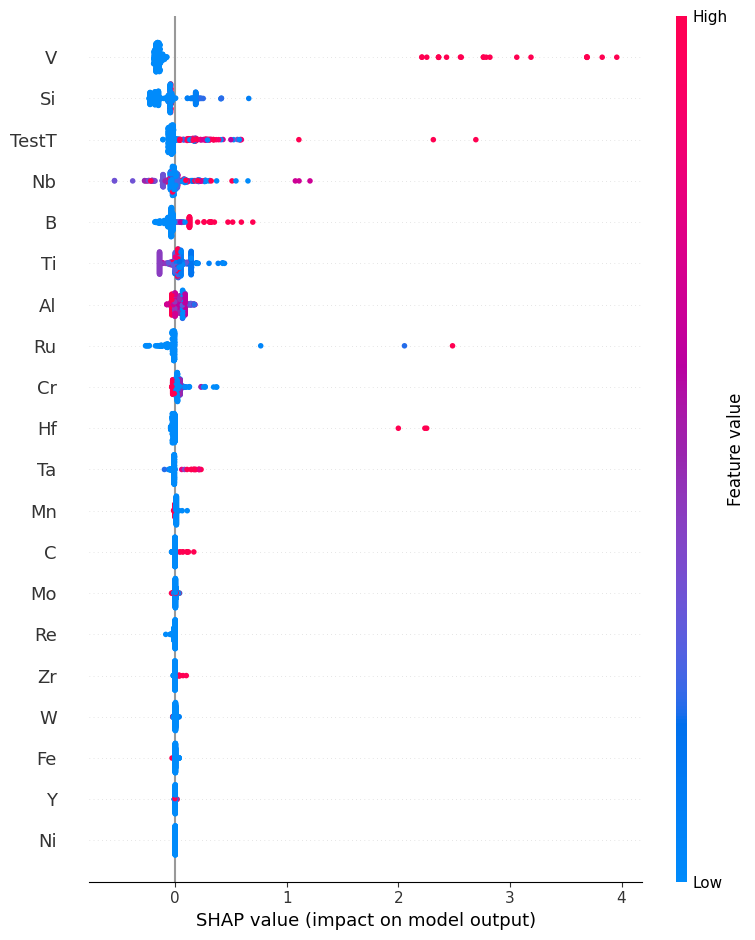

In [20]:
# Summary plot for logCost
shap.summary_plot(rf_shap_values[:,:,3])

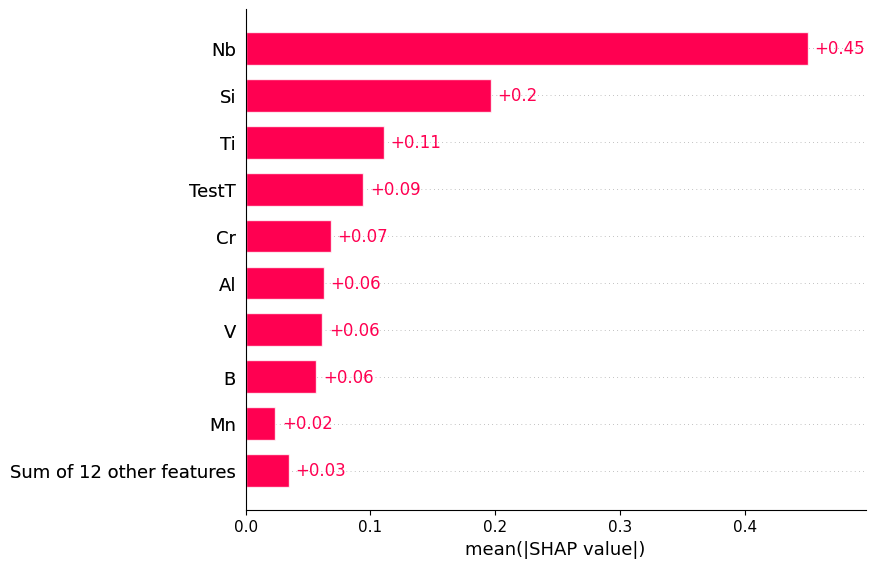

In [21]:
# Mean SHAP for logYS
shap.plots.bar(rf_shap_values[:,:,0])

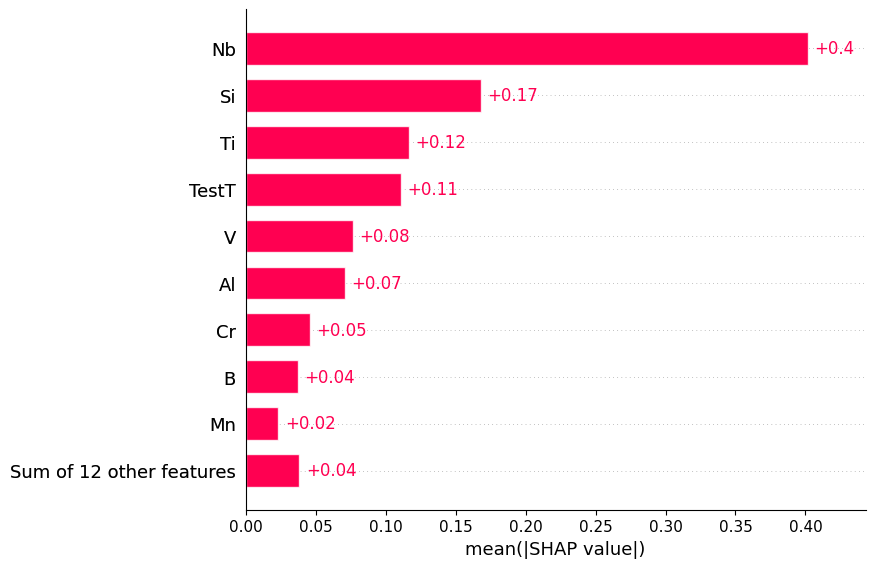

In [22]:
# Mean SHAP for logTS
shap.plots.bar(rf_shap_values[:,:,1])

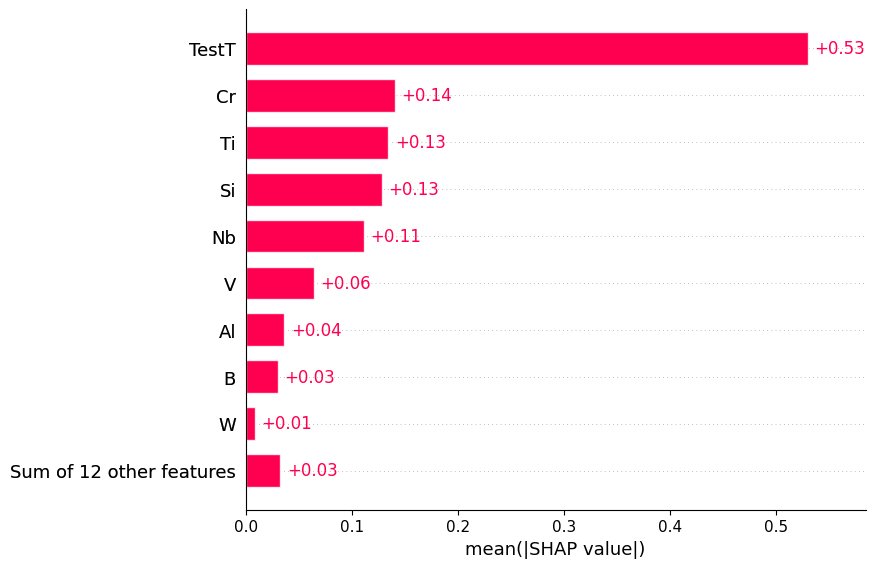

In [23]:
# Mean SHAP for logEl
shap.plots.bar(rf_shap_values[:,:,2])

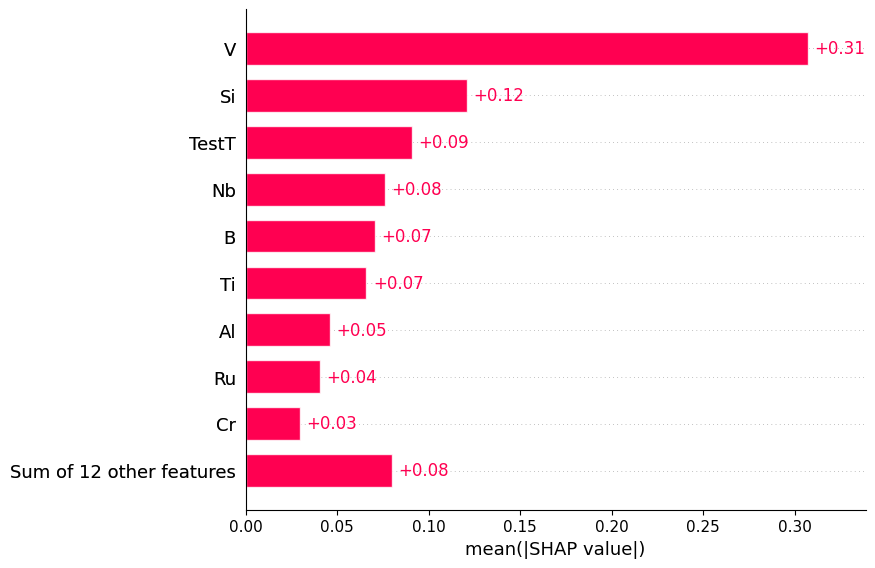

In [24]:
# Mean SHAP for logCost
shap.plots.bar(rf_shap_values[:,:,3])

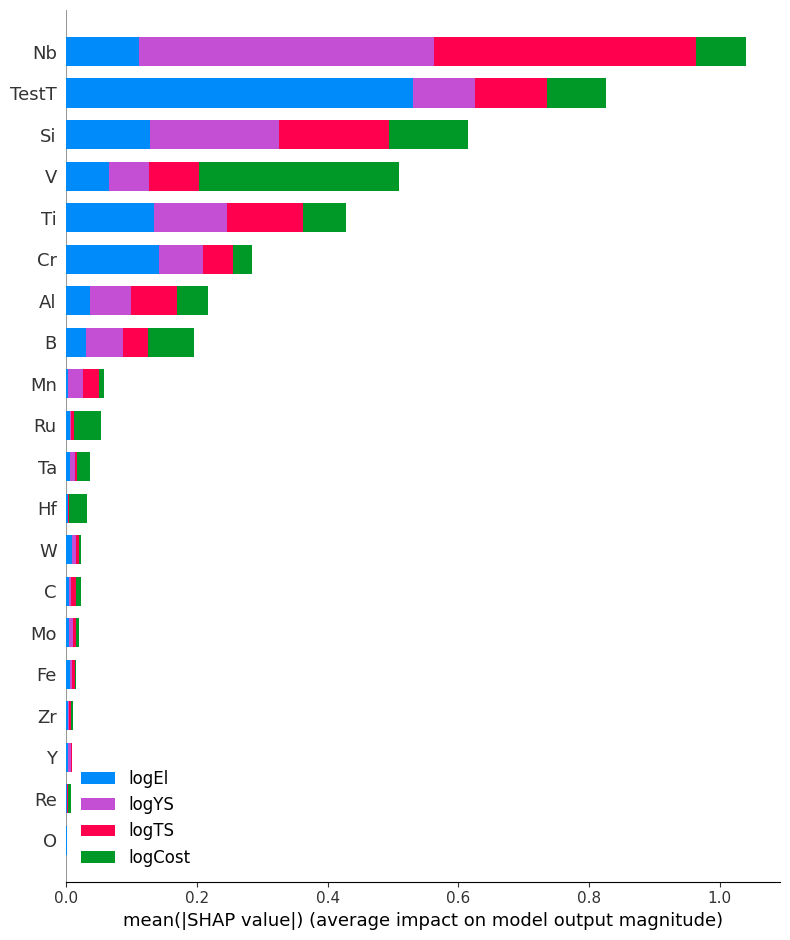

In [111]:
# Overall Summary plot
rf_shap_list = [rf_shap_values.values[:,:,0],rf_shap_values.values[:,:,1],rf_shap_values.values[:,:,2],rf_shap_values.values[:,:,3]]
shap.summary_plot(rf_shap_list, features=X_test, class_names=response)

### Bayesian Optimization

In [22]:
# Define our search space
x_space = [Real(0.01,100),Real(0.01,100),Integer(0,0.001),Real(0.01,10),Real(0.01,10)]
for i in range(5,20):
    x_space.append(Integer(0,0.001))
x_space.append(Integer(298,298.1))
x_space

[Real(low=0.01, high=100, prior='uniform', transform='identity'),
 Real(low=0.01, high=100, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Real(low=0.01, high=10, prior='uniform', transform='identity'),
 Real(low=0.01, high=10, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='id

In [23]:
def f(X):
    x_init = np.array(X).reshape(1,-1)
    comp = x_init[:-1]/sum(x_init[:-1])*100
    x = np.append(comp,x_init[-1]).reshape(1,-1)
    transformed = scalerX.transform(x)
    y_pred = rfregressor.predict(transformed)
    predicted = scalerY.inverse_transform(y_pred)
    
    target_err_1 = 0
    for i in range(len(target)):
        if target[i] != None:
            target_err_1 = target_err_1 + weight[i]*abs(target[i] - predicted[0][i])
    
    objective = target_err_1
    
    return objective

In [24]:
#Targets
targets = [[np.log10(700),np.log10(900),np.log10(4.5),np.log10(2.5)],
           [np.log10(700),np.log10(900),np.log10(4.5),np.log10(3)]]

In [25]:
targets_df = pd.DataFrame(targets)
targets_df.to_excel("MPR_RF_BO_Targets-RT.xlsx")

In [26]:
weight = [1, 1, 1, 1, 1, 1, 1]

In [27]:
fl_nm=[]
for i in range(len(targets)):
    fl_nm.append('wCostmod'+'-'+str(i+1))
fl_nm

['wCostmod-1', 'wCostmod-2']

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have val

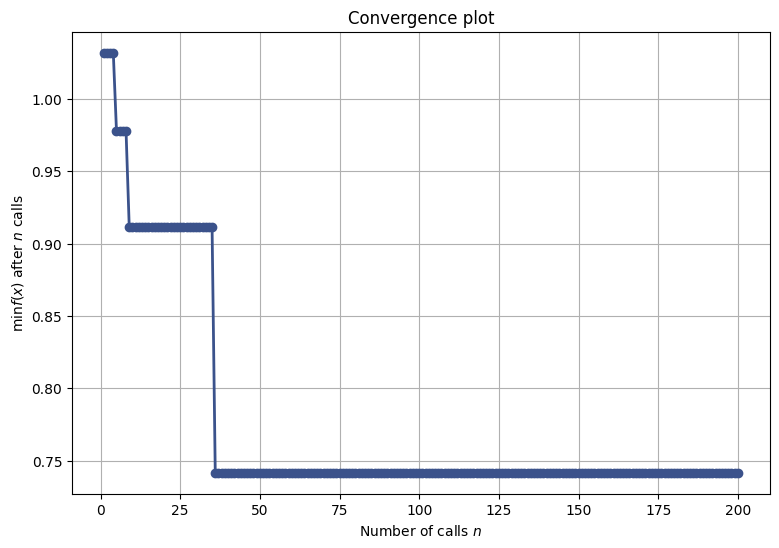

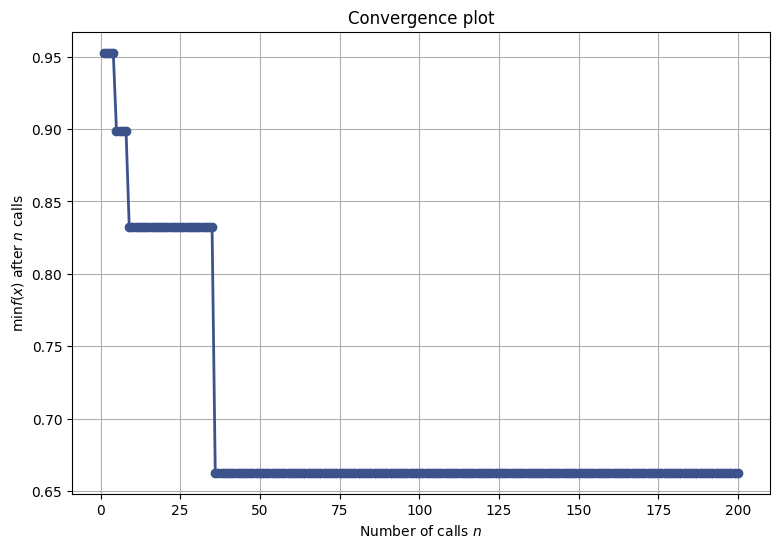

In [28]:
for i in range(len(targets)):
    target = targets[i]
    res = gp_minimize(f,                  # the function to minimize
                      x_space,      # the bounds on each dimension of x
                      acq_func="EI",      # the acquisition function
                      n_calls=200,         # the number of evaluations of f
                      n_random_starts=5,  # the number of random initialization points
                      random_state=42,   # the random seed
                      xi=0.01,           # Exploration or Exploitation
                      n_jobs=-1)
    
    fig, ax = plt.subplots(1,1,figsize=(9,6))
    ax = plot_convergence(res)
    filename = f'Convergence_{i+1}_RFR.png'
    fig.savefig('Plots/'+filename)

    for j in range(200):
        results = res.x_iters[j]
        comp_res = np.round(results[:-1]/sum(results[:-1])*100,2)
        results_mod = np.append(comp_res,results[-1])
        temp1 = pd.DataFrame(results_mod.reshape(1,-1), columns=features, index=[j])
        transformed = scalerX.transform(temp1)
        y_pred = rfregressor.predict(transformed)
        predicted = scalerY.inverse_transform(y_pred)
        temp2 = pd.DataFrame(predicted, columns=response, index=[j])
        temp3 = pd.DataFrame(np.round(res.func_vals[j],2), columns = ['Objective'], index=[j])
        if j==0:
            temp_db = pd.concat([temp1,temp2,temp3],axis=1)
        else:
            temp4 = pd.concat([temp1,temp2,temp3],axis=1)
            temp_db = pd.concat([temp_db,temp4],axis=0)
    
    temp_db = temp_db.sort_values('Objective')
    res_df = temp_db.iloc[:10,:]
    temp_db.to_excel('MPR_RF_BO_Target-RT_TiAl2Cr2Nb_'+fl_nm[i]+'.xlsx')
    res_df.to_excel('MPR_RF_BO_Target-RT_TiAl2Cr2Nb_'+fl_nm[i]+'_top10.xlsx')

### Composition 1 Properties Prediction

In [29]:
c1_data = pd.read_excel('MPR_RF_BO_Target-2-RT_TiAl2Cr2Nb_wCostmod-1.xlsx')
c1_data = c1_data.iloc[:10,1:22]
c1_data

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Si,W,C,B,Fe,Ru,Ni,Y,Re,TestT
0,63.67,30.86,0,2.14,3.34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
1,41.61,48.66,0,4.87,4.87,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
2,44.15,49.47,0,1.43,4.95,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
3,34.44,60.02,0,1.87,3.67,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
4,43.38,48.06,0,4.81,3.76,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
5,40.30,54.01,0,1.62,4.08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
6,41.85,53.46,0,2.17,2.52,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
7,46.37,49.13,0,1.93,2.57,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
8,39.11,52.89,0,5.29,2.71,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
9,47.33,47.33,0,2.92,2.43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298


In [30]:
c1_mean = round(c1_data.mean(axis=0),2)
c1_mean

Ti        44.22
Al        49.39
Mn         0.00
Nb         2.90
Cr         3.49
Mo         0.00
V          0.00
Zr         0.00
Hf         0.00
O          0.00
Ta         0.00
Si         0.00
W          0.00
C          0.00
B          0.00
Fe         0.00
Ru         0.00
Ni         0.00
Y          0.00
Re         0.00
TestT    298.00
dtype: float64

In [31]:
c1_mean_scaled = scalerX.transform(c1_mean.values.reshape(1,-1))
c1_prop_scaled = rfregressor.predict(c1_mean_scaled)
c1_prop = scalerY.inverse_transform(c1_prop_scaled)
c1_prop = np.round(10**c1_prop, 2)
c1_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[498.32, 580.  ,   0.67,   4.25]])

In [32]:
c1_prop_df = pd.DataFrame(c1_prop, columns=['YS','TS','El','Cost'])
c1_prop_df

,YS,TS,El,Cost
0,498.32,580.0,0.67,4.25


In [33]:
c1_prop_df.to_excel('MPR_RF_BO_Target-2-RT_TiAl2Cr2Nb_wCostmod-1_top10_Properties.xlsx')

### Composition 2 Properties Prediction

In [34]:
c2_data = pd.read_excel('MPR_RF_BO_Target-2-RT_TiAl2Cr2Nb_wCostmod-2.xlsx')
c2_data = c2_data.iloc[:10,1:22]
c2_data

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Si,W,C,B,Fe,Ru,Ni,Y,Re,TestT
0,63.67,30.86,0,2.14,3.34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
1,44.37,48.12,0,4.81,2.70,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
2,37.42,56.13,0,1.73,4.72,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
3,55.22,35.14,0,4.02,5.63,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
4,47.90,45.54,0,2.91,3.66,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
5,37.84,53.42,0,5.34,3.40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
6,40.56,54.67,0,1.98,2.79,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
7,47.71,47.70,0,1.41,3.19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
8,38.36,53.19,0,3.13,5.32,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
9,47.28,47.28,0,2.08,3.35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298


In [35]:
c2_mean = round(c2_data.mean(axis=0),2)
c2_mean

Ti        46.03
Al        47.21
Mn         0.00
Nb         2.95
Cr         3.81
Mo         0.00
V          0.00
Zr         0.00
Hf         0.00
O          0.00
Ta         0.00
Si         0.00
W          0.00
C          0.00
B          0.00
Fe         0.00
Ru         0.00
Ni         0.00
Y          0.00
Re         0.00
TestT    298.00
dtype: float64

In [36]:
c2_mean_scaled = scalerX.transform(c2_mean.values.reshape(1,-1))
c2_prop_scaled = rfregressor.predict(c2_mean_scaled)
c2_prop = scalerY.inverse_transform(c2_prop_scaled)
c2_prop = np.round(10**c2_prop, 2)
c2_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[490.68, 582.31,   1.01,   4.86]])

In [37]:
c2_prop_df = pd.DataFrame(c2_prop, columns=['YS','TS','El','Cost'])
c2_prop_df

,YS,TS,El,Cost
0,490.68,582.31,1.01,4.86


In [38]:
c2_prop_df.to_excel('MPR_RF_BO_Target-2-RT_TiAl2Cr2Nb_wCostmod-2_top10_Properties.xlsx')

### Reference Composition Properties

In [39]:
ref_comp = [48, 48, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 298]
ref_comp = np.array(ref_comp).reshape(1,-1)
ref_comp_df = pd.DataFrame(ref_comp, columns=features)
ref_comp_df

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Si,W,C,B,Fe,Ru,Ni,Y,Re,TestT
0,48,48,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298


In [40]:
ref_comp_scaled = scalerX.transform(ref_comp)
ref_prop_scaled = rfregressor.predict(ref_comp_scaled)
ref_prop = scalerY.inverse_transform(ref_prop_scaled)
ref_prop = np.round(10**ref_prop, 2)
ref_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[456.61, 517.94,   0.52,   3.87]])

In [41]:
ref_prop_df = pd.DataFrame(ref_prop, columns=['YS','TS','El','Cost'])
ref_prop_df

,YS,TS,El,Cost
0,456.61,517.94,0.52,3.87


In [42]:
ref_prop_df.to_excel('MPR_RF_BO_Target-2-RT_TiAl2Cr2Nb_Ref_Properties.xlsx')

## MPR DNN model and BO

### Running 1st time

In [29]:
# Importing libraries for Neural Network Regression
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras import Sequential
from keras.layers import InputLayer, Dense, BatchNormalization

In [53]:
# Storing the hyperparameters in variable to develop the NN architecture
num_dense_layers = 11
units = 1029
activation = 'relu'
learning_rate = 4.161731258030334e-05
optimizer = 'Adam'
batchsize = 78
epochs = 100

In [54]:
# function to develop NN architecture with same number of units in all hidden layers
def build_and_compile_model(num_dense_layers,units,activation,lr,optimizer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1) #name of hidden layer
        model.add(Dense(units,activation=activation,name=name)) #add hidden layer(s)
    model.add(Dense(y_train.shape[1], activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [55]:
# Create the neural network with these hyper-parameters.
model1 = build_and_compile_model(num_dense_layers, units, activation, learning_rate, optimizer)
    
# Train the model.
history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batchsize, validation_split=0.2, verbose=0)

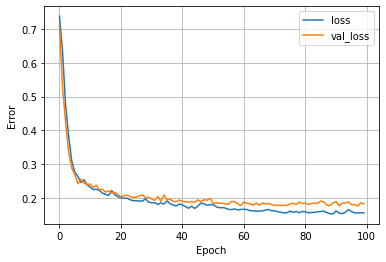

In [56]:
#function to plot the training and validation history of the NN
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

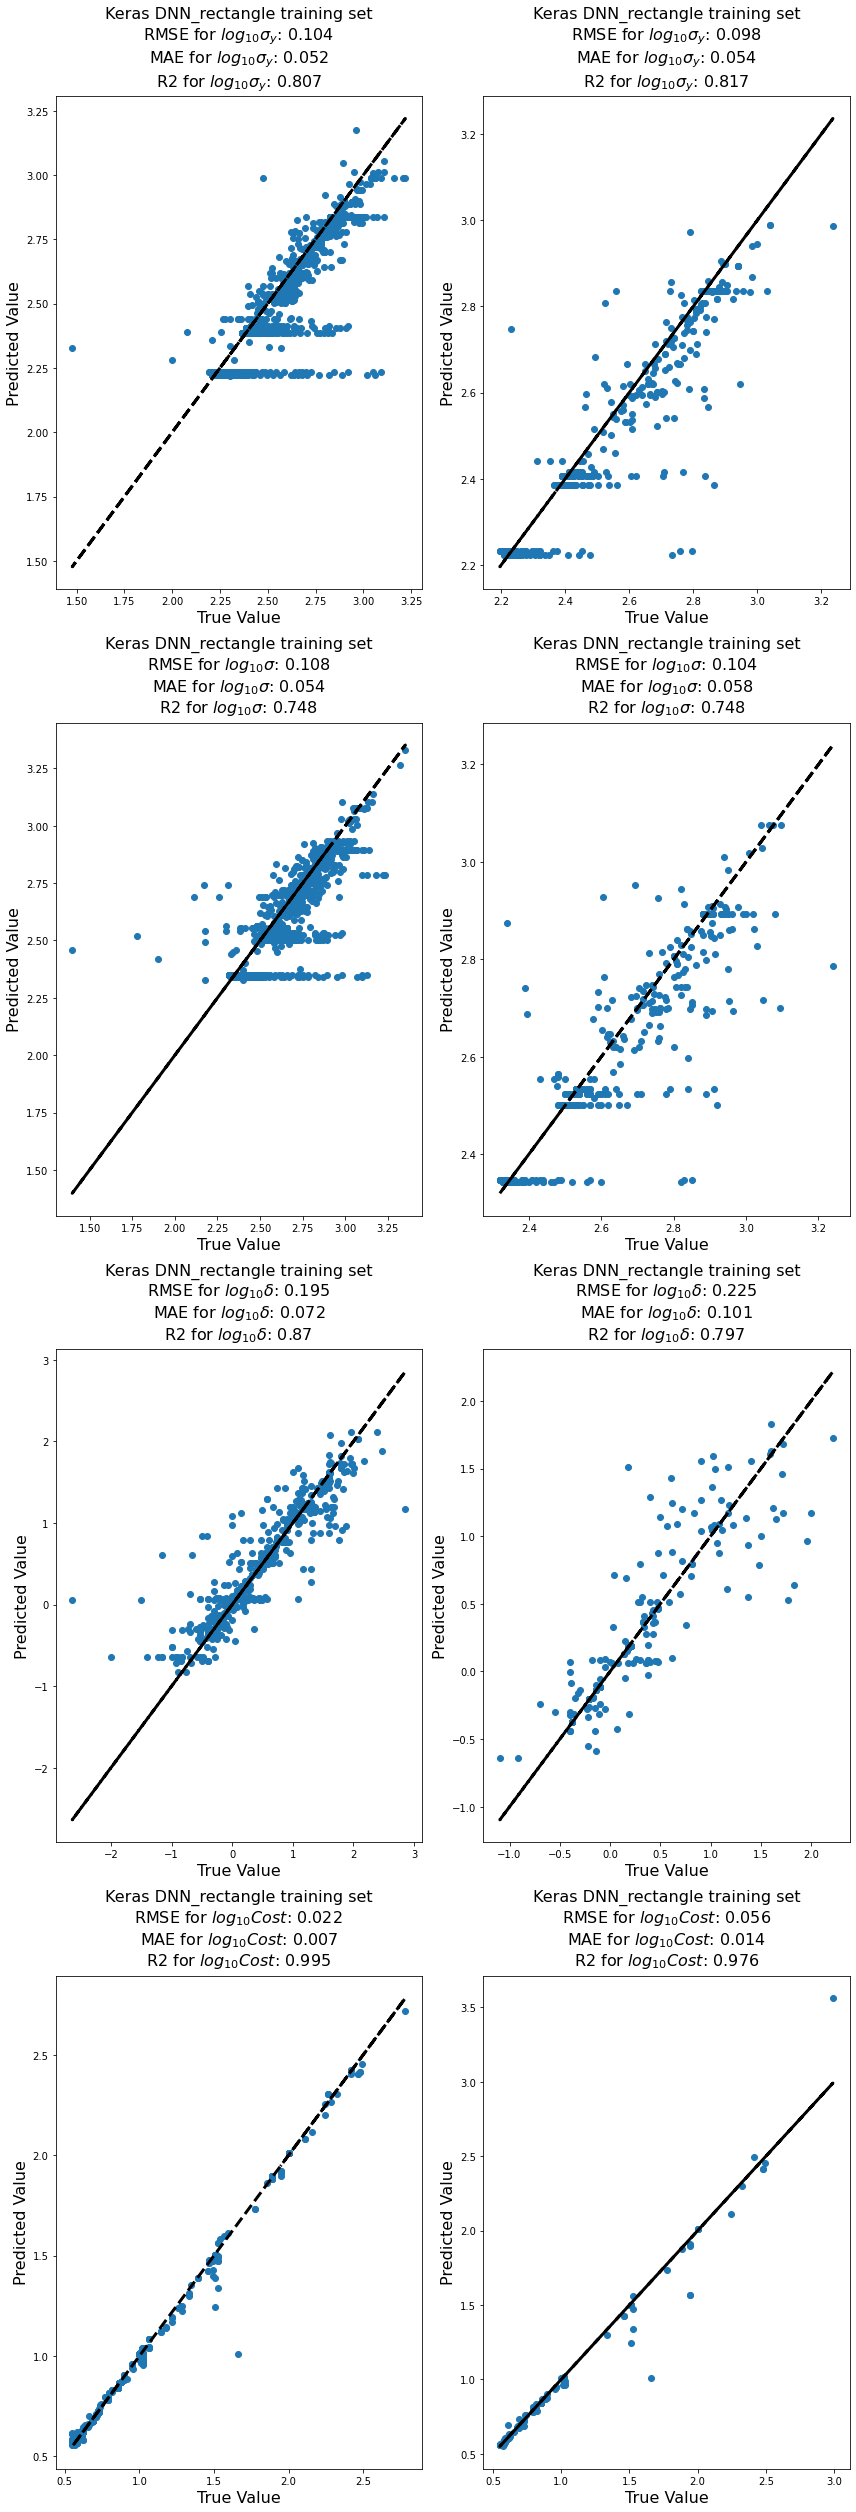

In [57]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model1.predict(X_train)
y_pred_test=model1.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Keras DNN_rectangle', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Keras DNN_rectangle'] = rmse
mae_scores['Keras DNN_rectangle'] = mae
R2_scores['Keras DNN_rectangle'] = R2

In [58]:
model1.save('MPR DNNrect model')

INFO:tensorflow:Assets written to: MPR DNNrect model\assets


### Loading the saved model

In [32]:
import tensorflow as tf

In [33]:
dnn_rect_model = tf.keras.models.load_model("MPR DNNrect model")
dnn_rect_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_dense_1 (Dense)       (None, 1029)              22638     
                                                                 
 layer_dense_2 (Dense)       (None, 1029)              1059870   
                                                                 
 layer_dense_3 (Dense)       (None, 1029)              1059870   
                                                                 
 layer_dense_4 (Dense)       (None, 1029)              1059870   
                                                                 
 layer_dense_5 (Dense)       (None, 1029)              1059870   
                                                                 
 layer_dense_6 (Dense)       (None, 1029)              1059870   
                                                                 
 layer_dense_7 (Dense)       (None, 1029)             

13/13 [==============================] - 0s 1ms/step


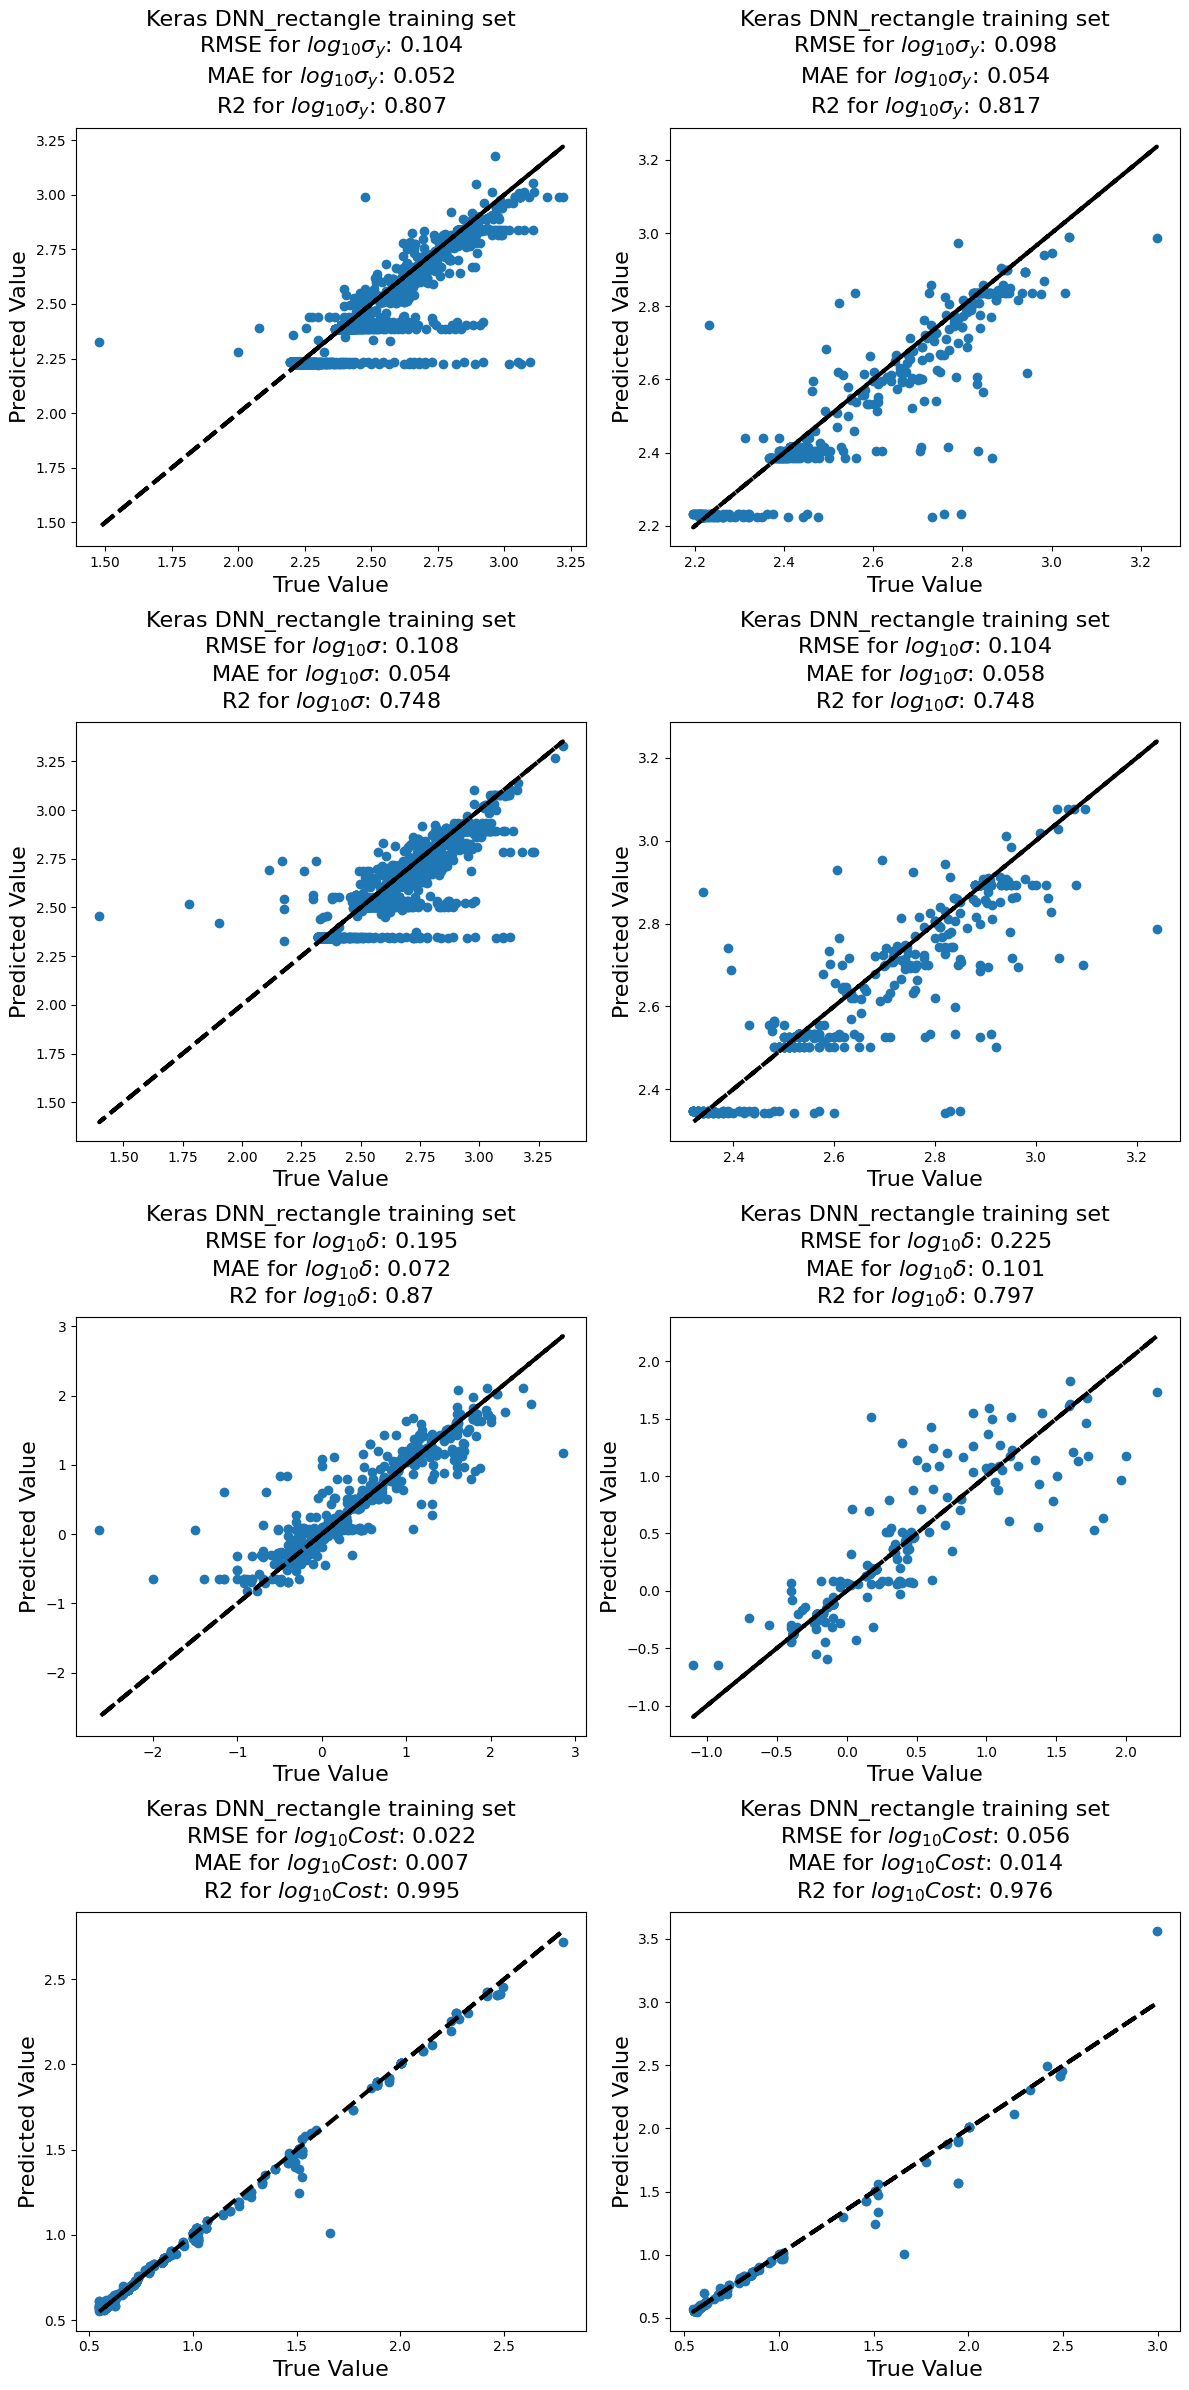

In [34]:
# Use the saved Keras model to predict on the training and test sets
y_pred_train=dnn_rect_model.predict(X_train)
y_pred_test=dnn_rect_model.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('Keras DNN_rectangle', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Keras DNN_rectangle'] = rmse
mae_scores['Keras DNN_rectangle'] = mae
R2_scores['Keras DNN_rectangle'] = R2

In [126]:
# Get SHAP values
dnnexplainer = shap.KernelExplainer(dnn_rect_model.predict, X_train.iloc[:100,:])
dnn_shap_values = dnnexplainer(X_test.iloc[:100,:])
np.shape(dnn_shap_values)

4/4 [==============================] - 0s 12ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

6507/6507 [==============================] - 15s 2ms/step


(100, 21, 4)

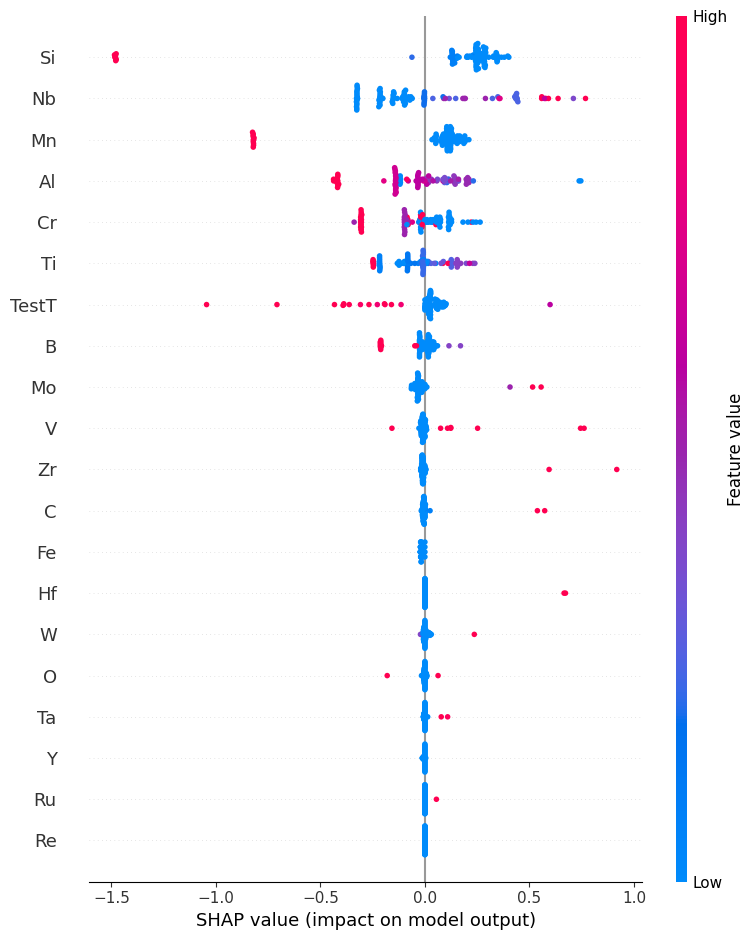

In [128]:
# Summary plot for logYS
shap.summary_plot(dnn_shap_values[:,:,0])

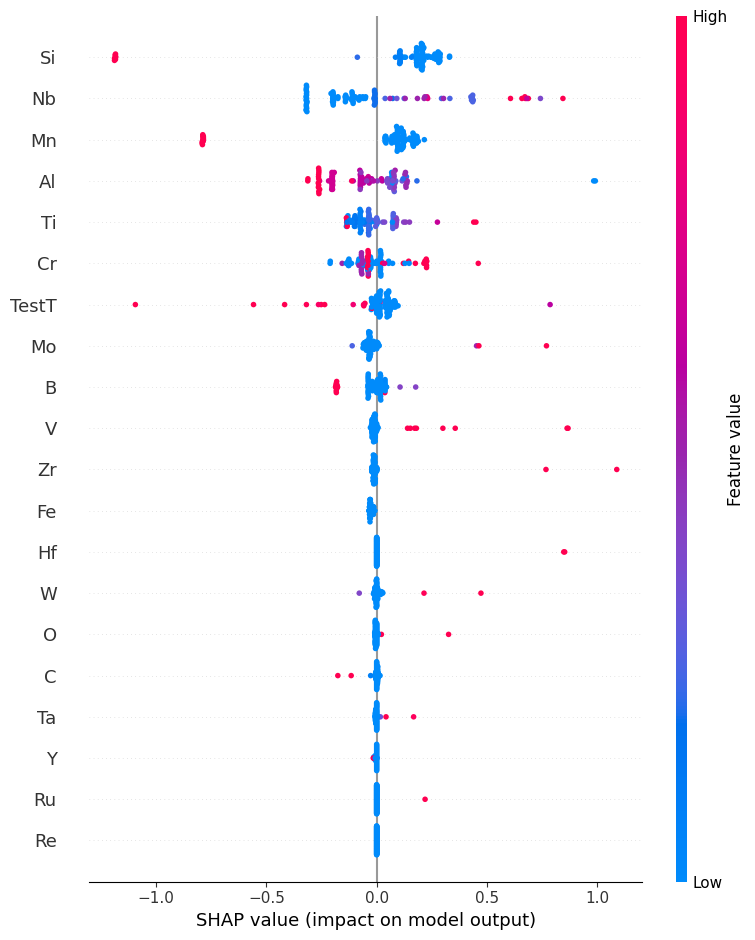

In [129]:
# Summary plot for logTS
shap.summary_plot(dnn_shap_values[:,:,1])

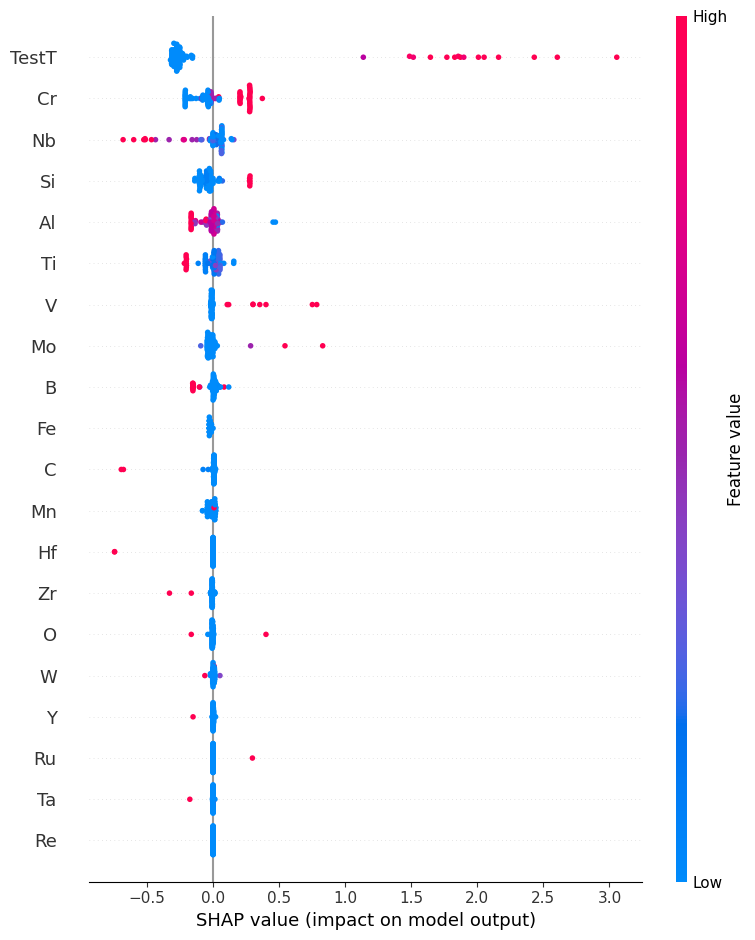

In [130]:
# Summary plot for logEl
shap.summary_plot(dnn_shap_values[:,:,2])

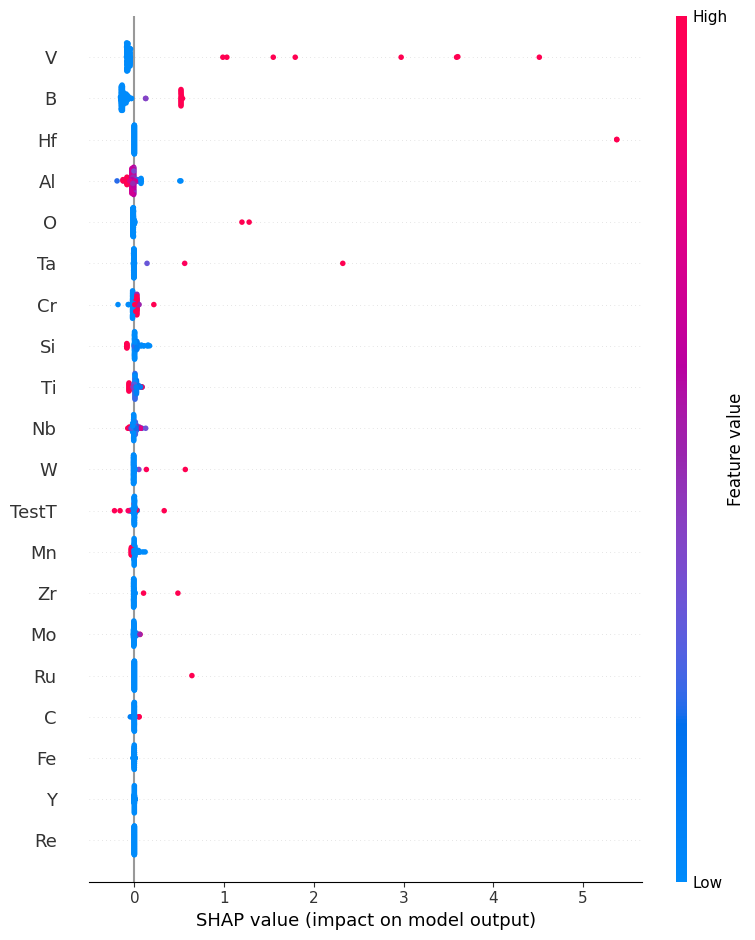

In [131]:
# Summary plot for logCost
shap.summary_plot(dnn_shap_values[:,:,3])

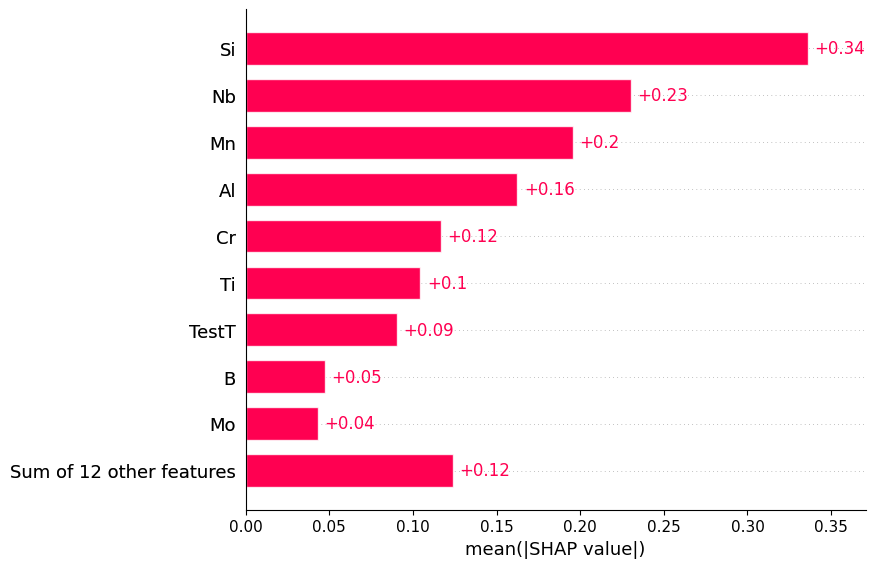

In [133]:
# Mean SHAP for logYS
shap.plots.bar(dnn_shap_values[:,:,0])

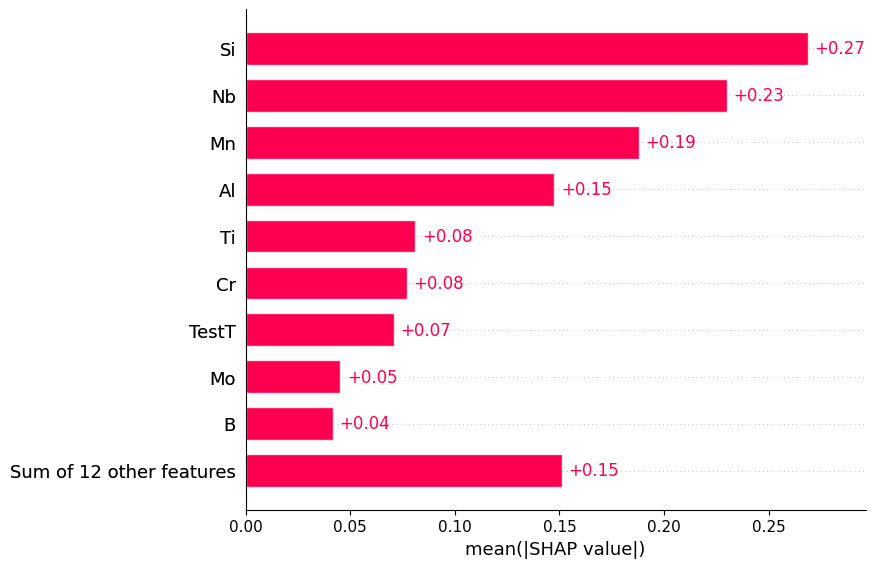

In [134]:
# Mean SHAP for logTS
shap.plots.bar(dnn_shap_values[:,:,1])

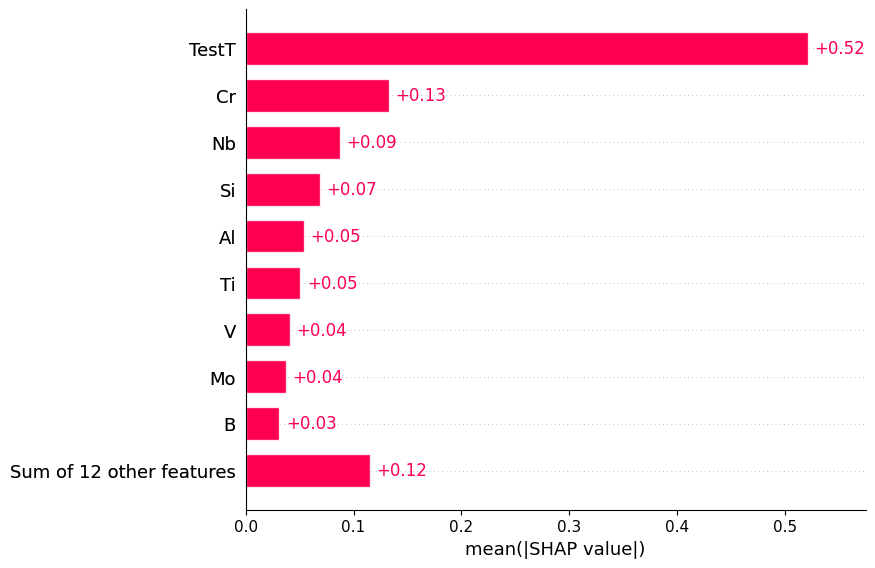

In [135]:
# Mean SHAP for logEl
shap.plots.bar(dnn_shap_values[:,:,2])

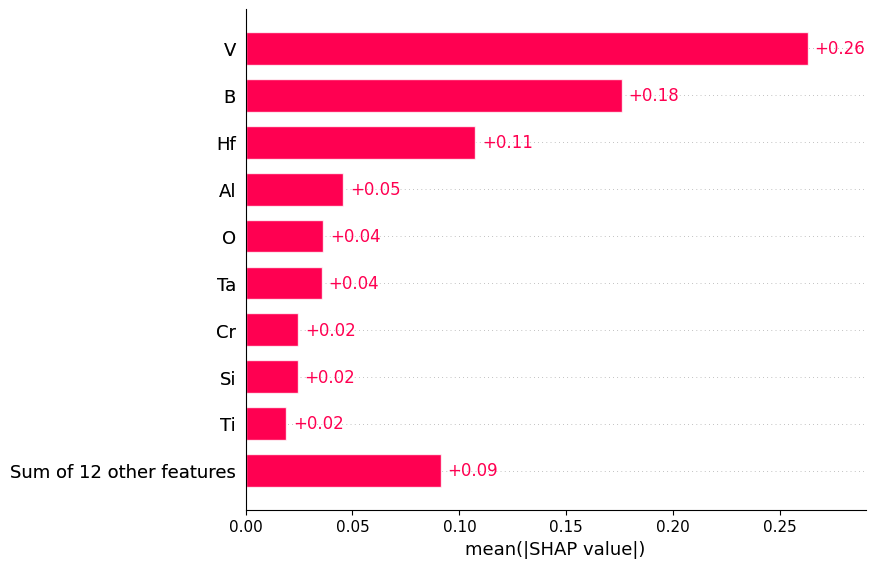

In [136]:
# Mean SHAP for logCost
shap.plots.bar(dnn_shap_values[:,:,3])

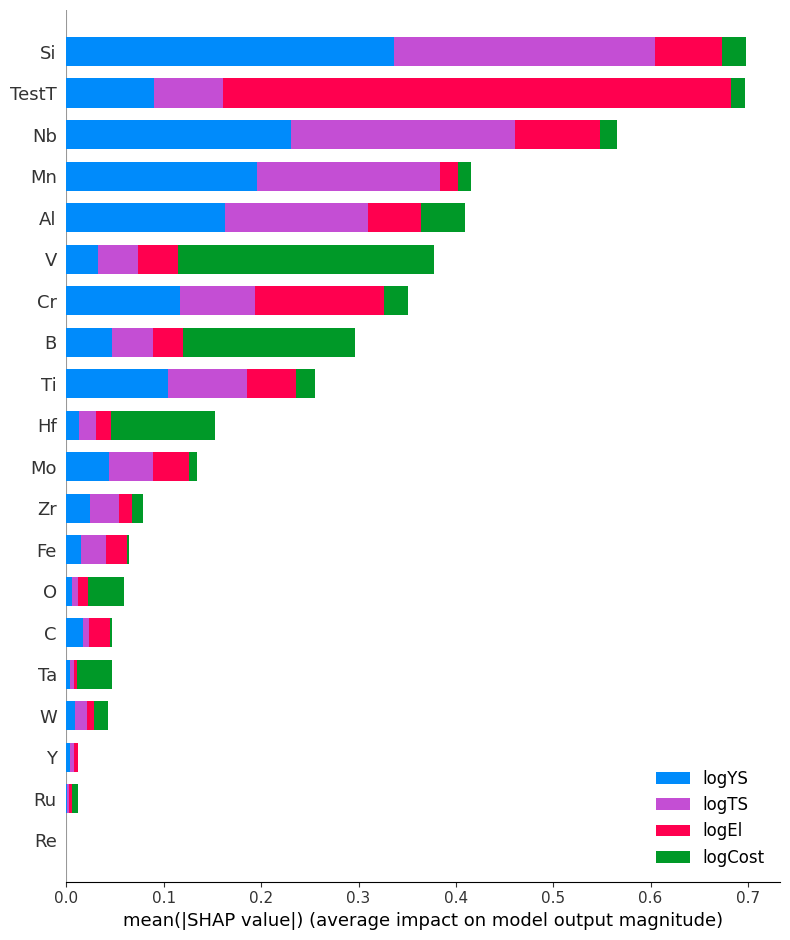

In [137]:
# Overall Summary plot
dnn_shap_list = [dnn_shap_values.values[:,:,0],dnn_shap_values.values[:,:,1],dnn_shap_values.values[:,:,2],dnn_shap_values.values[:,:,3]]
shap.summary_plot(dnn_shap_list, features=X_test.iloc[:100,:], class_names=response)

### Bayesian Optimization

In [35]:
# Define our search space
x_space = [Real(0.01,100),Real(0.01,100),Integer(0,0.001),Real(0.01,10),Real(0.01,10)]
for i in range(5,20):
    x_space.append(Integer(0,0.001))
x_space.append(Integer(298,298.1))
x_space

[Real(low=0.01, high=100, prior='uniform', transform='identity'),
 Real(low=0.01, high=100, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Real(low=0.01, high=10, prior='uniform', transform='identity'),
 Real(low=0.01, high=10, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='identity'),
 Integer(low=0, high=0.001, prior='uniform', transform='id

In [36]:
def f(X):
    x_init = np.array(X).reshape(1,-1)
    comp = x_init[:-1]/sum(x_init[:-1])*100
    x = np.append(comp,x_init[-1]).reshape(1,-1)
    transformed = scalerX.transform(x)
    y_pred = dnn_rect_model.predict(transformed)
    predicted = scalerY.inverse_transform(y_pred)
    
    target_err_1 = 0
    for i in range(len(target)):
        if target[i] != None:
            target_err_1 = target_err_1 + weight[i]*abs(target[i] - predicted[0][i])
    
    objective = target_err_1
    
    return objective

In [38]:
#Targets
targets = [[np.log10(700),np.log10(900),np.log10(4.5),np.log10(2.5)],
           [np.log10(700),np.log10(900),np.log10(4.5),np.log10(3)]]

In [39]:
targets_df = pd.DataFrame(targets)
targets_df.to_excel("MPR_DNNrect_BO_Targets-RT.xlsx")

In [40]:
weight = [1, 1, 1, 1, 1, 1, 1]

In [41]:
fl_nm=['wCostmod-1','wCostmod-2']
for i in range(len(targets)-2):
    fl_nm.append('wCostmod'+'-'+str(i+2))
fl_nm

['wCostmod-1', 'wCostmod-2']

1/1 [==============================] - 0s 115ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 28ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 10ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 29ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 29ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 7ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 31ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 38ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 12ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 29ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 12ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 10ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 12ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 7ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 9ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 35ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 10ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 31ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 31ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 30ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 28ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 34ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 10ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 29ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 26ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 24ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 6ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 25ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 30ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 32ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 7ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 30ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 27ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 18ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 23ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 28ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 21ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 15ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 17ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 14ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 12ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 20ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 13ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 22ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 16ms/step


X does not have valid feature names, but StandardScaler was fitted with feature names


1/1 [==============================] - 0s 19ms/step


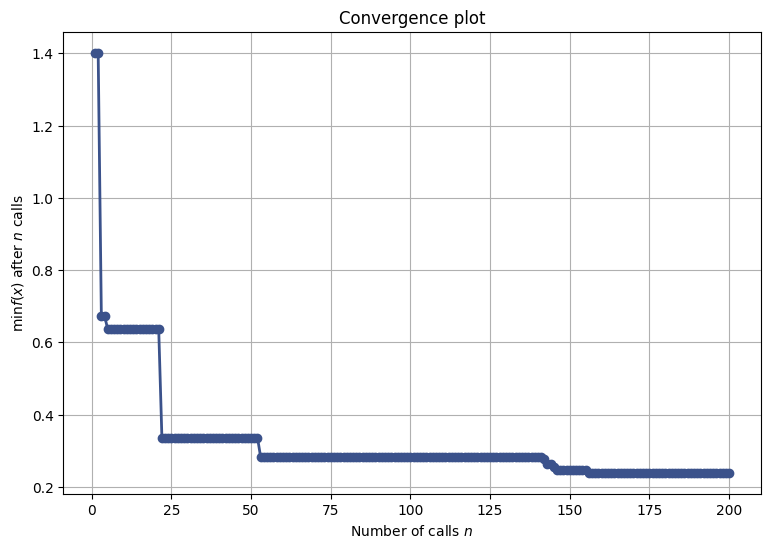

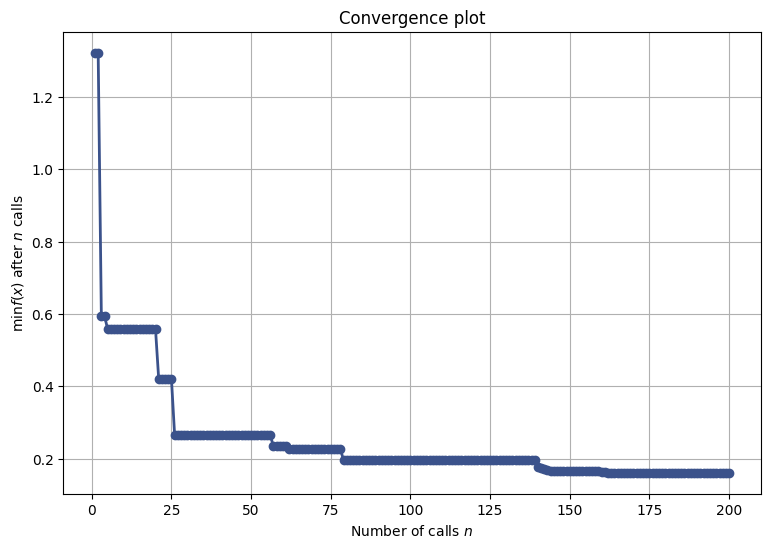

In [42]:
for i in range(len(targets)):
    target = targets[i]
    res = gp_minimize(f,                  # the function to minimize
                      x_space,      # the bounds on each dimension of x
                      acq_func="EI",      # the acquisition function
                      n_calls=200,         # the number of evaluations of f
                      n_random_starts=5,  # the number of random initialization points
                      random_state=42,   # the random seed
                      xi=0.001,           # Exploration or Exploitation
                      n_jobs=-1)
    
    fig, ax = plt.subplots(1,1,figsize=(9,6))
    ax = plot_convergence(res)
    filename = f'Convergence_{i+1}_DNNrect.png'
    fig.savefig('Plots/'+filename)

    for j in range(200):
        results = res.x_iters[j]
        comp_res = np.round(results[:-1]/sum(results[:-1])*100,2)
        results_mod = np.append(comp_res,results[-1])
        temp1 = pd.DataFrame(results_mod.reshape(1,-1), columns=features, index=[j])
        transformed = scalerX.transform(temp1)
        y_pred = dnn_rect_model.predict(transformed)
        predicted = scalerY.inverse_transform(y_pred)
        temp2 = pd.DataFrame(predicted, columns=response, index=[j])
        temp3 = pd.DataFrame(np.round(res.func_vals[j],3), columns = ['Objective'], index=[j])
        if j==0:
            temp_db = pd.concat([temp1,temp2,temp3],axis=1)
        else:
            temp4 = pd.concat([temp1,temp2,temp3],axis=1)
            temp_db = pd.concat([temp_db,temp4],axis=0)
    
    temp_db = temp_db.sort_values('Objective')
    res_df = temp_db.iloc[:10,:]
    temp_db.to_excel('MPR_DNNrect_BO_Target-RT_TiAl2Cr2Nb_'+fl_nm[i]+'.xlsx')
    res_df.to_excel('MPR_DNNrect_BO_Target-RT_TiAl2Cr2Nb_'+fl_nm[i]+'_top10.xlsx')

### Composition 1 Properties Prediction

In [ ]:
c1_data = pd.read_excel('MPR_DNNrect_BO_Target-2-RT_TiAl2Cr2Nb_wCostmod-1.xlsx')
c1_data = c1_data.iloc[:10,1:22]
c1_data

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Si,W,C,B,Fe,Ru,Ni,Y,Re,TestT
0,63.67,30.86,0,2.14,3.34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
1,41.61,48.66,0,4.87,4.87,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
2,44.15,49.47,0,1.43,4.95,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
3,34.44,60.02,0,1.87,3.67,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
4,43.38,48.06,0,4.81,3.76,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
5,40.30,54.01,0,1.62,4.08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
6,41.85,53.46,0,2.17,2.52,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
7,46.37,49.13,0,1.93,2.57,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
8,39.11,52.89,0,5.29,2.71,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
9,47.33,47.33,0,2.92,2.43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298


In [ ]:
c1_mean = round(c1_data.mean(axis=0),2)
c1_mean

Ti        44.22
Al        49.39
Mn         0.00
Nb         2.90
Cr         3.49
Mo         0.00
V          0.00
Zr         0.00
Hf         0.00
O          0.00
Ta         0.00
Si         0.00
W          0.00
C          0.00
B          0.00
Fe         0.00
Ru         0.00
Ni         0.00
Y          0.00
Re         0.00
TestT    298.00
dtype: float64

In [ ]:
c1_mean_scaled = scalerX.transform(c1_mean.values.reshape(1,-1))
c1_prop_scaled = rfregressor.predict(c1_mean_scaled)
c1_prop = scalerY.inverse_transform(c1_prop_scaled)
c1_prop = np.round(10**c1_prop, 2)
c1_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[498.32, 580.  ,   0.67,   4.25]])

In [ ]:
c1_prop_df = pd.DataFrame(c1_prop, columns=['YS','TS','El','Cost'])
c1_prop_df

,YS,TS,El,Cost
0,498.32,580.0,0.67,4.25


In [ ]:
c1_prop_df.to_excel('MPR_DNNrect_BO_Target-2-RT_TiAl2Cr2Nb_wCostmod-1_top10_Properties.xlsx')

### Composition 2 Properties Prediction

In [ ]:
c2_data = pd.read_excel('MPR_DNNrect_BO_Target-2-RT_TiAl2Cr2Nb_wCostmod-2.xlsx')
c2_data = c2_data.iloc[:10,1:22]
c2_data

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Si,W,C,B,Fe,Ru,Ni,Y,Re,TestT
0,63.67,30.86,0,2.14,3.34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
1,44.37,48.12,0,4.81,2.70,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
2,37.42,56.13,0,1.73,4.72,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
3,55.22,35.14,0,4.02,5.63,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
4,47.90,45.54,0,2.91,3.66,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
5,37.84,53.42,0,5.34,3.40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
6,40.56,54.67,0,1.98,2.79,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
7,47.71,47.70,0,1.41,3.19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
8,38.36,53.19,0,3.13,5.32,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298
9,47.28,47.28,0,2.08,3.35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298


In [ ]:
c2_mean = round(c2_data.mean(axis=0),2)
c2_mean

Ti        46.03
Al        47.21
Mn         0.00
Nb         2.95
Cr         3.81
Mo         0.00
V          0.00
Zr         0.00
Hf         0.00
O          0.00
Ta         0.00
Si         0.00
W          0.00
C          0.00
B          0.00
Fe         0.00
Ru         0.00
Ni         0.00
Y          0.00
Re         0.00
TestT    298.00
dtype: float64

In [ ]:
c2_mean_scaled = scalerX.transform(c2_mean.values.reshape(1,-1))
c2_prop_scaled = rfregressor.predict(c2_mean_scaled)
c2_prop = scalerY.inverse_transform(c2_prop_scaled)
c2_prop = np.round(10**c2_prop, 2)
c2_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[490.68, 582.31,   1.01,   4.86]])

In [ ]:
c2_prop_df = pd.DataFrame(c2_prop, columns=['YS','TS','El','Cost'])
c2_prop_df

,YS,TS,El,Cost
0,490.68,582.31,1.01,4.86


In [ ]:
c2_prop_df.to_excel('MPR_DNNrect_BO_Target-2-RT_TiAl2Cr2Nb_wCostmod-2_top10_Properties.xlsx')

### Reference Composition Properties

In [ ]:
ref_comp = [48, 48, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 298]
ref_comp = np.array(ref_comp).reshape(1,-1)
ref_comp_df = pd.DataFrame(ref_comp, columns=features)
ref_comp_df

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Si,W,C,B,Fe,Ru,Ni,Y,Re,TestT
0,48,48,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,298


In [ ]:
ref_comp_scaled = scalerX.transform(ref_comp)
ref_prop_scaled = rfregressor.predict(ref_comp_scaled)
ref_prop = scalerY.inverse_transform(ref_prop_scaled)
ref_prop = np.round(10**ref_prop, 2)
ref_prop

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


array([[456.61, 517.94,   0.52,   3.87]])

In [ ]:
ref_prop_df = pd.DataFrame(ref_prop, columns=['YS','TS','El','Cost'])
ref_prop_df

,YS,TS,El,Cost
0,456.61,517.94,0.52,3.87


In [ ]:
ref_prop_df.to_excel('MPR_DNNrect_BO_Target-2-RT_TiAl2Cr2Nb_Ref_Properties.xlsx')